In [9]:
import keras
from keras.utils import to_categorical
from keras.utils import load_img, img_to_array
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten,Conv2D, BatchNormalization,Activation,MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import networkx as nx

def create_adjacency_matrix(image, num_nodes=64):
    h, w = image.shape[:2]
    points = np.random.rand(num_nodes, 2)
    points[:, 0] *= w
    points[:, 1] *= h
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    
    # Connect each point to its k nearest neighbors
    k = 5
    for i, point in enumerate(points):
        distances = [np.linalg.norm(point - other_point) for other_point in points]
        nearest = np.argsort(distances)[1:k+1]  # Exclude self
        for j in nearest:
            G.add_edge(i, j)
    
    return nx.adjacency_matrix(G).toarray()

In [2]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224), color_mode="rgb")
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = preprocess_image(image)
        features.append(img)
    return np.array(features)

In [3]:
def prepare_graph_data(images):
    adjacency_matrices = []
    for image in tqdm(images):
        img = preprocess_image(image)
        adj_matrix = create_adjacency_matrix(img)
        adjacency_matrices.append(adj_matrix)
    return np.array(adjacency_matrices)

In [4]:
def prepare_data(train_dir, test_dir):
    # Create dataframes
    def create_dataframe(dir):
        image_paths = []
        labels = []
        for label in os.listdir(dir):
            for imagename in os.listdir(os.path.join(dir,label)):
                image_paths.append(os.path.join(dir,label,imagename))
                labels.append(label)
            print(label,'done')
        return pd.DataFrame({'image': image_paths, 'label': labels})

    train_df = create_dataframe(train_dir)
    test_df = create_dataframe(test_dir)

    # Extract features
    x_train = extract_features(train_df['image'])
    x_test = extract_features(test_df['image'])

    # Prepare graph data
    A_train = prepare_graph_data(train_df['image'])
    A_test = prepare_graph_data(test_df['image'])

    # Encode labels
    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_test = le.transform(test_df['label'])

    # Convert to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return x_train, A_train, y_train, x_test, A_test, y_test, le.classes_

# Usage
x_train, A_train, y_train, x_test, A_test, y_test, class_names = prepare_data('Data/train', 'Data/test')

angry done
disgusted done
fearful done
happy done
neutral done
sad done
surprised done
angry done
disgusted done
fearful done
happy done
neutral done
sad done
surprised done


100%|██████████| 7178/7178 [01:56<00:00, 61.49it/s]


In [34]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, a_set, batch_size=32, shuffle=True):
        self.x, self.y, self.a = x_set, y_set, a_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x[indexes]
        y_batch = self.y[indexes]
        a_batch = self.a[indexes]

        # Ensure that the return type is a tuple of tensors
        return (tf.convert_to_tensor(x_batch), tf.convert_to_tensor(a_batch)), tf.convert_to_tensor(y_batch)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [35]:
# Assuming x_train, y_train, A_train, x_test, y_test, A_test are your data arrays
train_generator = DataGenerator(x_train, y_train, A_train, batch_size=32)
test_generator = DataGenerator(x_test, y_test, A_test, batch_size=32, shuffle=False)

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Add, Concatenate, Input, Dropout, Reshape
from tensorflow.keras.layers import Layer

class GraphConvLayer(Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        super(GraphConvLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][-1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(GraphConvLayer, self).build(input_shape)

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)
        output = tf.matmul(output, self.kernel)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.output_dim)

def residual_block(x, filters):
    y = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(y)
    y = BatchNormalization()(y)
    residual = Conv2D(filters, kernel_size=(1, 1), padding="same")(x)  
    y = Add()([residual, y])
    y = MaxPooling2D()(y) 
    return y

def inception_module(x, filters):
    branch1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    branch3x3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(branch3x3)
    
    branch5x5 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(branch5x5)
    
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters, (1, 1), padding='same', activation='relu')(branch_pool)
    
    outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
    return Concatenate(axis=-1)(outputs)

def dense_block(x, units, dropout_rate):
    x = Dense(units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    return x

# Define number of nodes in the graph and number of classes
num_nodes = 64  
class_counts = 7

input_layer = Input(shape=(224, 224, 3)) 
x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Residual blocks
x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)
x = residual_block(x, 512)

# Inception modules
x = inception_module(x, 256)
x = inception_module(x, 128)
x = inception_module(x, 64)

# Additional convolutional layers
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Flatten layer
x = Flatten()(x)

# Define adjacency matrix placeholder
A = Input(shape=(num_nodes, num_nodes))

# Reshape x to match the number of nodes
x_reshaped = Dense(num_nodes)(x)
x_reshaped = Reshape((num_nodes, -1))(x_reshaped)

# GCN Layer 1
gcn_output = GraphConvLayer(output_dim=64, activation='relu')([x_reshaped, A])

# GCN Layer 2
gcn_output = GraphConvLayer(output_dim=32, activation='relu')([gcn_output, A])

# Flatten GCN output
gcn_output_flatten = Flatten()(gcn_output)

concatenated_output = Concatenate()([x, gcn_output_flatten])

# Dense layers
x = dense_block(concatenated_output, 512, 0.5) 
x = dense_block(x, 256, 0.3)   
x = dense_block(x, 128, 0.2)   

# Output layer
output_layer = Dense(class_counts, activation="softmax")(x)

# Create model
cnn_gcn_model = Model(inputs=[input_layer, A], outputs=output_layer)

# Compile the model
cnn_gcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Print model summary
cnn_gcn_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_315 (Conv2D) │ (None, 224, 224,  │        896 │ input_layer_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_315[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_90    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_316 (Conv2D) │ (None, 112, 112,  │      9,248 │ max_pooling2d_90… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_316[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_317 (Conv2D) │ (None, 112, 112,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_318 (Conv2D) │ (None, 112, 112,  │      1,056 │ max_pooling2d_90… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_317[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 112, 112,  │          0 │ conv2d_318[0][0], │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_91    │ (None, 56, 56,    │          0 │ add_45[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_319 (Conv2D) │ (None, 56, 56,    │     18,496 │ max_pooling2d_91… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_319[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_320 (Conv2D) │ (None, 56, 56,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_321 (Conv2D) │ (None, 56, 56,    │      2,112 │ max_pooling2d_91… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_320[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 56, 56,    │          0 │ conv2d_321[0][0]

 Total params: 11,706,023 (44.65 MB)

 Trainable params: 11,700,967 (44.64 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [43]:
history = cnn_gcn_model.fit(
    train_generator,
    validation_data=test_generator,
    batch_size=28,
    steps_per_epoch = 100,
    epochs=200
)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3155 - loss: 1.6844

c:\Users\Soham R\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.3155 - loss: 1.6845 - val_accuracy: 0.2893 - val_loss: 1.7330
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.3017 - loss: 1.6917 - val_accuracy: 0.2771 - val_loss: 1.7614
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.3463 - loss: 1.6261 - val_accuracy: 0.3417 - val_loss: 1.6382
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.3402 - loss: 1.6392 - val_accuracy: 0.3407 - val_loss: 1.6014
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3518 - loss: 1.5969 - val_accuracy: 0.3312 - val_loss: 1.6713
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3572 - loss: 1.5664 - val_accuracy: 0.3456 - val_loss: 1.6110
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3767 - loss: 1.5325 - val_accuracy: 0.3496 - val_loss: 1.6476
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.4047 - loss: 1.5003 - val_accuracy

c:\Users\Soham R\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.3837 - loss: 1.5428 - val_accuracy: 0.3661 - val_loss: 1.5630
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.4122 - loss: 1.4838 - val_accuracy: 0.3933 - val_loss: 1.4880
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3991 - loss: 1.4848 - val_accuracy: 0.3871 - val_loss: 1.5301
Epoch 12/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.4004 - loss: 1.4758 - val_accuracy: 0.2232 - val_loss: 1.9192
Epoch 13/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.4074 - loss: 1.4910 - val_accuracy: 0.2912 - val_loss: 1.7251
Epoch 14/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.4203 - loss: 1.4549 - val_accuracy: 0.2341 - val_loss: 1.8461
Epoch 15/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.4106 - loss: 1.4283 - val_accuracy: 0.2747 - val_loss: 1.7943
Epoch 16/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.4269 - loss: 1.4219 - val_a

KeyboardInterrupt: 

In [44]:
model_json = cnn_gcn_model.to_json()
with open("gcnv1.json",'w') as json_file:
    json_file.write(model_json)
cnn_gcn_model.save("gcnv1.h5")


In [45]:
cnn_gcn_model.save('gcnv1.keras')

NameError: name 'history' is not defined

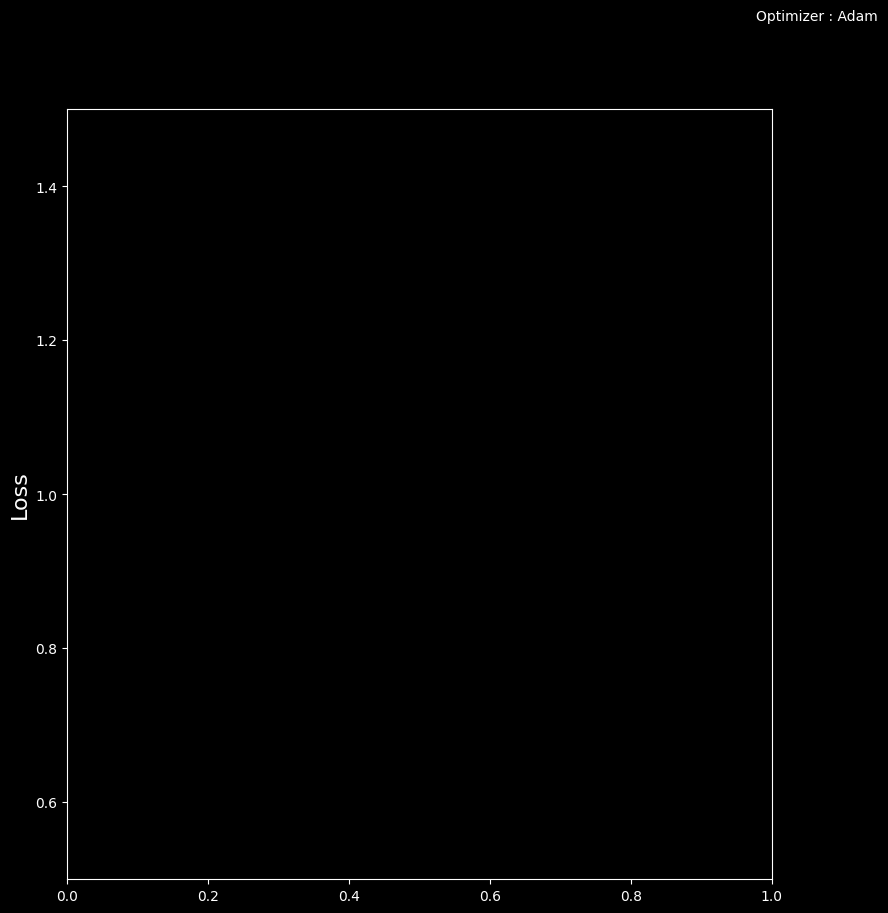

In [48]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)

# Define fixed y-axis range for loss (replace with your desired values)
plt.ylim(0.5, 1.5)  # Adjust these values as needed

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)

# Define fixed y-axis range for accuracy (replace with your desired values)
plt.ylim(0.3, 0.9)  # Adjust these values as needed

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()
